## **Phase 1: Product Categorization via Unsupervised Learning**
This notebook details the first phase of the analysis: transforming raw, uncategorized transactional data into a structured set of product categories. The primary challenge is the lack of pre-existing categories for thousands of unique `StockCodes`.

**Methodology:**
1.  **Feature Engineering:** Convert alphanumeric `StockCode`s into a purely numerical format suitable for clustering algorithms.
2.  **Algorithmic Clustering:** Use Hierarchical Agglomerative Clustering to identify the latent structure within the product data.
3.  **Iterative Refinement:** Employ a "human-in-the-loop" approach, combining NLP (noun extraction) with rule-based logic to manually refine and re-categorize the dense, generic clusters that the algorithm could not effectively separate.

In [ ]:

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly import subplots
import mlxtend as mlx
import numpy as np
import pandas as pd
import statsmodels
from sklearn.preprocessing import StandardScaler
from IPython.display import display, HTML, Image
import plotly.io as pio
import plotly.express as px
import json
from urllib.request import urlopen
from collections import Counter
import string
import re
import scipy
import scipy.cluster
pio.templates.default = "plotly_dark"

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 50

# Convert scientific notation to plain numbers
pd.options.display.float_format = '{:.2f}'.format

def display_side_by_side(*args):
    html_str = '<div style="display: flex; justify-content: flex-start;"'
    for df in args:
        if isinstance(df, pd.Series):
            df = df.to_frame()
        html_str += f'<div style="flex: 1; padding: 0;"{df.to_html(index=True)}</div'
    html_str += '</div'
    
    display(HTML(html_str))


### **1. Data Loading and Initial Inspection**
We begin by loading the cleaned dataset generated from the previous EDA notebook (`online_sales_pos_stock.parquet`). This file contains all completed, positive-value transactions.

In [8]:
#Read the parquet file that we generated on our other notebook
df = pd.read_parquet('online_sales_pos_stock.parquet', engine = "fastparquet")
display_side_by_side(df.head())
display_side_by_side(df.tail())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceDay,InvoiceHour,CustomerID_str
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,15.30,2010-12-01,8,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12-01,8,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,22.00,2010-12-01,8,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12-01,8,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12-01,8,17850


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceDay,InvoiceHour,CustomerID_str
527752,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.00,France,10.20,2011-12-09,12,12680
527753,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.00,France,12.60,2011-12-09,12,12680
527754,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.00,France,16.60,2011-12-09,12,12680
527755,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.00,France,16.60,2011-12-09,12,12680
527756,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.00,France,14.85,2011-12-09,12,12680


### **2. Preparing Data for Clustering: Stock Code Analysis**
The goal of this phase is to group items based on their `StockCode` and `UnitPrice`. To do this, we first create a new dataframe containing only unique stock codes to analyze their structure.

An initial analysis of the string lengths reveals that standard product codes consistently have a length of **5** (numeric) or **6** (numeric with a letter suffix). As we will confirm next, other lengths often correspond to administrative charges (e.g., 'POST', 'Manual') or gift cards, which are not physical products and should be excluded from this clustering exercise.

In [9]:
#Let's focus on trying to cluster by Stock Codes and Price
price_code_df = df[['StockCode', 'UnitPrice', 'Description']]
price_code_df = price_code_df.drop_duplicates(subset='StockCode')

price_code_df['CodeLength'] = price_code_df['StockCode'].str.len()
print(price_code_df['CodeLength'].unique())

[ 6  5  7 12  1]


#### **2.1. Investigating Non-Standard Code Lengths**
Before filtering, we will investigate the descriptions associated with the uncommon code lengths seen above (1, 7, 12) to confirm our hypothesis. The table below shows that these codes indeed correspond to manual entries, gift cards, and a single outlier product with a non-standard code format. We will exclude the gift cards and manual entries.


In [10]:
unique_lengths = price_code_df[price_code_df['CodeLength'].isin([7,12,1])]
unqiue_lists = unique_lengths['StockCode'].to_list()

unique_desc = df[['StockCode', 'Description']][df['StockCode'].isin(unqiue_lists)]
unique_desc = unique_desc.drop_duplicates(subset='StockCode')
unique_desc

,StockCode,Description
131,15056BL,EDWARDIAN PARASOL BLACK
5265,15056bl,EDWARDIAN PARASOL BLACK
37319,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00
39330,m,Manual
40894,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00
43482,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00
43550,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00
109301,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00


### **3. Feature Engineering: Transforming `StockCode` for Clustering**

To use `StockCode` as a feature for clustering, we must first convert it into a numerical format. A key hypothesis of this analysis is that the numbering system used by the business contains a latent, inherent structure; items with numerically similar `StockCode`s are likely related. We can leverage this by transforming the codes into floats in a way that **maintains the relative placement and proximity of each item to one another.**

The primary challenge is handling the alphanumeric suffixes (e.g., '84406B', '15056bl') which denote item variants. Simply removing these letters would group all variants together, while a standard encoding might disrupt the crucial numerical sequence.

The chosen solution addresses both issues:
1.  **Preserve Proximity:** By converting the codes to a `float` type, we maintain the base numerical order.
2.  **Encode Variants:** Each alphabetic suffix is mapped to a unique decimal value. For example, 'A' becomes '.01', 'B' becomes '.02', etc., with a separate range for uppercase letters.

This technique creates the `StockCodeFloat` feature (e.g., '84406B' becomes `84406.52`), a numerical representation that preserves the base item's position while uniquely encoding its variants as decimal extensions. This makes the feature perfectly suited for distance-based clustering algorithms.

In [11]:
price_code_df_filtered = price_code_df[price_code_df['CodeLength'].isin([5,6,7])] 
price_code_df_filtered[price_code_df_filtered['StockCode'].str.contains(r'[a-z]$')]

,StockCode,UnitPrice,Description,CodeLength
5265,15056bl,12.72,EDWARDIAN PARASOL BLACK,7
5266,15056p,12.72,EDWARDIAN PARASOL PINK,6
5333,47566b,8.47,TEA TIME PARTY BUNTING,6
5334,72349b,4.21,SET/6 PURPLE BUTTERFLY T-LIGHTS,6
5338,84872a,11.02,TEATIME FUNKY FLOWER BACKPACK FOR 2,6
...,...,...,...,...
479717,85049c,2.46,ROMANTIC PINKS RIBBONS,6
488590,84971l,2.46,LARGE HEART FLOWERS HOOK,6
488591,85034b,8.29,3 WHITE CHOC MORRIS BOXED CANDLES,6
495849,85179a,2.46,GREEN BITTY LIGHT CHAIN,6


In [12]:
price_code_df_filtered['StockCodeFloat'] = price_code_df_filtered['StockCode']

lowercase_letters = list(string.ascii_lowercase)
uppercase_letters = list(string.ascii_uppercase)

lowercase_values = [round(0.01 * (i + 1), 2) for i in range(26)]
uppercase_values = [round(0.51 + (0.01 * i), 2) for i in range(26)]

combined_dict = {letter: value for letter, value in zip(lowercase_letters + uppercase_letters, lowercase_values + uppercase_values)}
updated_dict = {k: f"{v:.2f}".lstrip('0') for k, v in combined_dict.items()}


#Create string replacements for bl and BL first to handle the onlu unique case present before replacing the single letter characters in a more standardized way
price_code_df_filtered['StockCodeFloat'] = price_code_df_filtered['StockCodeFloat'].str.replace('bl', '.30')
price_code_df_filtered['StockCodeFloat'] = price_code_df_filtered['StockCodeFloat'].str.replace('BL', '.80')

pattern = '|'.join(map(re.escape, updated_dict.keys()))

price_code_df_filtered['StockCodeFloat'] = price_code_df_filtered['StockCodeFloat'].str.replace(pattern, lambda x: updated_dict[x.group()], regex=True)
price_code_df_filtered['StockCodeFloat'] = price_code_df_filtered['StockCodeFloat'].astype(float)

### **4. Visualization & Algorithm Selection**
Before modeling, we visualize the engineered `StockCodeFloat` against `UnitPrice` to test our hypothesis that a latent structure exists in the product numbering system.

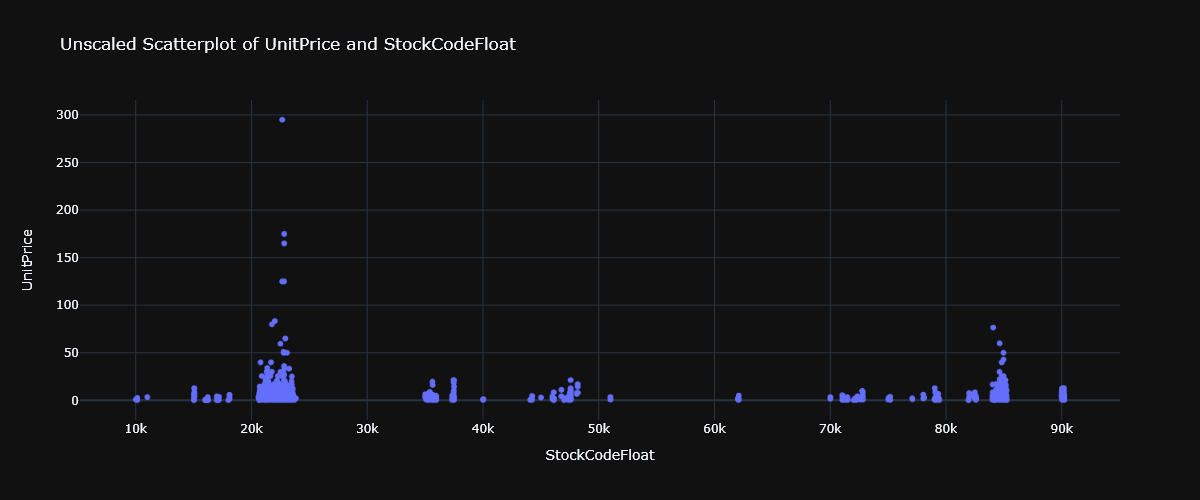

In [13]:
import sklearn
import sklearn.preprocessing 

scatter_base = px.scatter(x='StockCodeFloat' , y='UnitPrice', data_frame=price_code_df_filtered, title='Unscaled Scatterplot of UnitPrice and StockCodeFloat', width=1200)
#scatter_base.show()
#pio.write_image(scatter_base, r'unscaled_scatter.png')

Image('notebook referenced files\\unscaled_scatter.png')


**Figure 1: Latent Structure in Product Data**
    
The scatter plot reveals a distinct structure. The data forms clear, vertically-oriented clusters, indicating that items with similar numerical `StockCode` prefixes often share a product family but can have a wide range of prices.

The non-spherical, elongated shape of these clusters is critical. It immediately shows that an algorithm like K-Means, which assumes circular clusters, would perform poorly. This visual evidence strongly justifies using a density-based or hierarchical algorithm that can capture these complex shapes.

---

#### **4.1. Evaluating the Impact of Scaling**
As a due diligence step, we check if applying `StandardScaler` improves the visualization. While scaling is often necessary, in this case, it distorts the inherent numerical ranges of the `StockCode`s, making the plot less interpretable. Therefore, we will proceed with the unscaled data to preserve the original structure.

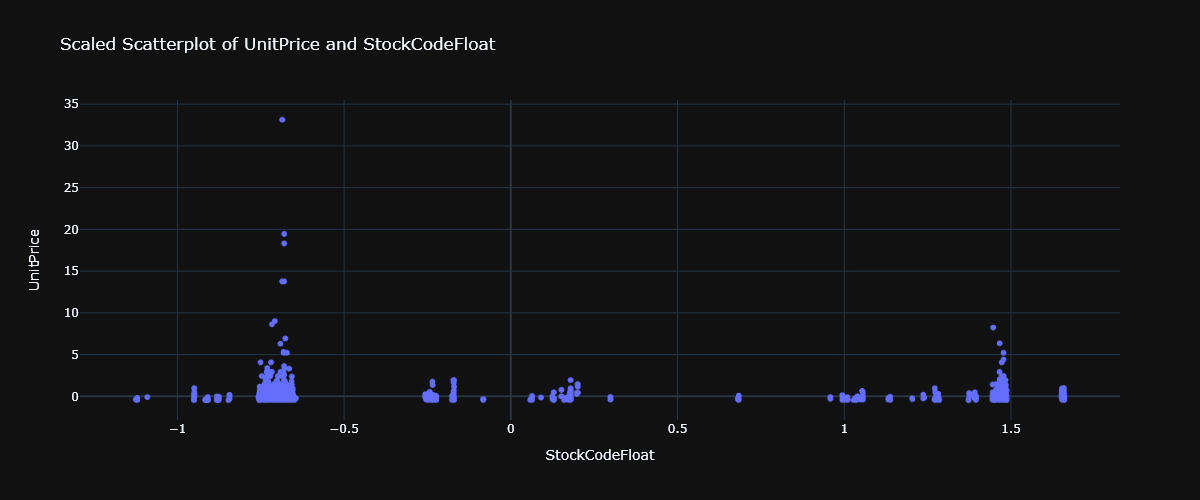

In [14]:

#Check if scaling affects our scatterplot
scaler = sklearn.preprocessing.StandardScaler()
price_code_df_scaled = scaler.fit_transform(price_code_df_filtered[['StockCodeFloat', 'UnitPrice']])
price_code_df_scaled = pd.DataFrame(price_code_df_scaled, columns=['StockCodeFloat', 'UnitPrice'])
price_code_df_scaled
scatter_base_scaled = px.scatter(x='StockCodeFloat' , y='UnitPrice', data_frame=price_code_df_scaled,  title='Scaled Scatterplot of UnitPrice and StockCodeFloat', width=1200)
#scatter_base_scaled.show()

#pio.write_image(scatter_base_scaled, r'scaled_scatter.png')

Image('notebook referenced files\\scaled_scatter.png')

### **5. Phase 1 Modeling: Hierarchical Agglomerative Clustering**
Based on the visual analysis, Hierarchical Agglomerative Clustering is the ideal algorithm. It groups points based on proximity without assuming a specific cluster shape, making it perfect for the observed vertical structures.

-   **Linkage Method:** `'complete'` is used to ensure that clusters are compact and well-separated.
-   **Criterion:** A `distance` threshold of `2000` is chosen after experimentation with the dendrogram, as it effectively partitions the main product groups.

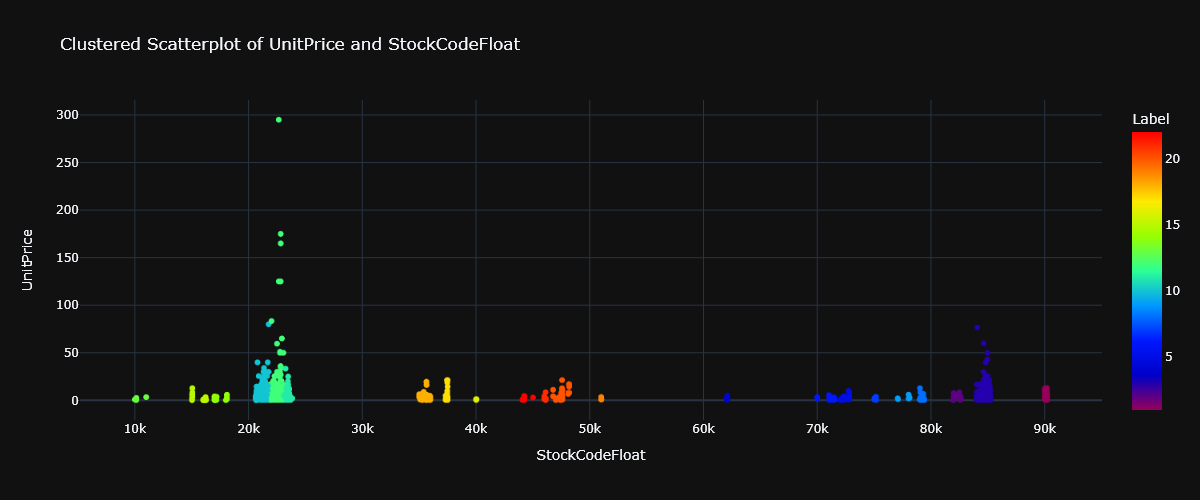

In [15]:
dm = scipy.cluster.hierarchy.linkage(price_code_df_filtered[['UnitPrice', 'StockCodeFloat']],
method='complete', metric='euclidean')

price_code_df_filtered['Label'] = scipy.cluster.hierarchy.fcluster(dm, t = 2000 , criterion = 'distance')

clustered_scatter = px.scatter(x='StockCodeFloat' , y='UnitPrice', color='Label', data_frame=price_code_df_filtered, height=500, color_continuous_scale='rainbow', title='Clustered Scatterplot of UnitPrice and StockCodeFloat', width=1200)

#pio.write_image(clustered_scatter, r'clustered_scatter.png')

Image('notebook referenced files\\clustered_scatter.png')


**Figure 2: Initial Algorithmic Segmentation Results**

The clustering algorithm successfully identifies 21 distinct product categories. However, one cluster (the large green group, labeled '10') is extremely dense and contains the vast majority of products (approximately 75% of total revenue). This "catch-all" cluster is too generic to be useful and requires a more nuanced approach.

---

### **6. Iterative Refinement: A "Human-in-the-Loop" Approach**
The initial clustering provided a solid baseline, but the generic nature of Cluster 10 requires manual refinement. To achieve this, we will use a "human-in-the-loop" strategy, combining NLP with rule-based logic.

The first step is to use the `nltk` library to extract the most common nouns from the `Description` of items within each cluster. This will help us identify the underlying themes and manually assign meaningful category names.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import nltk
from nltk import pos_tag, word_tokenize

#To help with generating Label names, we will use the function below to extract specific nouns from the Description column
def extract_nouns(text):
    """
    Extracts common nouns from a given text string.

    This function tokenizes the input text, converts it to lowercase, and uses part-of-speech tagging to identify and extract common nouns (singular and plural). The extracted nouns are returned as a single string.

    Parameters:
    text (str): The input text from which to extract nouns.

    Returns:
    str: A space-separated string of extracted nouns.
    """

    text_lower = text.lower()
    words = word_tokenize(text_lower)
    tagged_words = pos_tag(words)
    nouns = [word for word, tag in tagged_words if tag in ('NN', 'NNS')]
    return ' '.join(nouns)


#Create Nouns column with function above
price_code_df_filtered['Nouns'] = price_code_df_filtered['Description'].apply(extract_nouns)


#### **6.1. Analyzing Noun Frequencies in Each Cluster**
The `check_label_contents` function automates the process of analyzing each cluster. For a given label number, it calculates the frequency of all nouns in the item descriptions, providing a statistical basis for naming the category.

In [ ]:

#Now we can check each label with the help of the function below
def check_label_contents(num, df, return_info = False):
    """
    Analyze and display information about items with a specific label in a DataFrame to aid in Category creation by calculating the frequency of each noun in the 'Nouns' column. The most frequent 
    words are printed, and a sorted subset of the DataFrame is displayed. Optionally, the filtered DataFrame can be returned.

    Parameters:
    num (int): The label number to filter by.
    df (pd.DataFrame): The DataFrame containing item data, including 'Label', 'Nouns', 'StockCode', and 'Description'.
    return_df (bool): If True, returns the filtered and sorted DataFrame. Default is False.

    Returns:
    pd.DataFrame (optional): The filtered and sorted DataFrame if return_df is True.

    Displays:
    - A list of the 20 most frequent words in the 'Nouns' column for the specified label.
    - Two side-by-side tables showing the first and last 20 rows of the filtered DataFrame if it contains 40 or more rows.
      Otherwise, displays all rows.
    """

    #Filter df by label and drop duplicates
    label_filtered = df[df['Label'] == num ]
    label_filtered = label_filtered.drop_duplicates(subset=['StockCode', 'Description'])

    # Get a list of all the words, standardized to lowercase and counts the frequency of each noun
    unique_descriptions = list(label_filtered['Nouns'])
    all_text = ' '.join(unique_descriptions)
    words = all_text.lower().split()
    word_counts = Counter(words)

    # Sort the words by frequency and display 20 most frequent nouns
    sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))
    most_frequent_words = list(sorted_word_counts.keys())[:20]
    print(word_counts.most_common(10))

    #Display subset of df that can aid in naming Label, optionally return sorted and label filtered df for further analysis
    sorted_df = label_filtered.sort_values(by='StockCodeFloat', ascending=True)
    sorted_df_info = sorted_df[['StockCodeFloat', 'Description', 'Nouns', 'UnitPrice']]
    if len(sorted_df) == 40:
        display_side_by_side(sorted_df_info[:15], sorted_df_info[-15:])
    else:
        display_side_by_side(sorted_df_info[:])
    
    if return_info:
        return sorted_df, word_counts

#Example output
group_df, word_counts = check_label_contents(10, price_code_df_filtered, True)



[('retrospot', 43), ('vintage', 41), ('bag', 40), ('glass', 34), ('box', 34), ('polkadot', 33), ('heart', 29), ('cover', 28), ('paper', 26), ('pink', 23)]


,StockCodeFloat,Description,Nouns,UnitPrice
5045,20615.00,BLUE POLKADOT PASSPORT COVER,polkadot passport cover,2.10
2047,20616.00,CHERRY BLOSSOM PASSPORT COVER,cherry blossom passport cover,2.10
2433,20617.00,FIRST CLASS PASSPORT COVER,class passport cover,4.21
17531,20618.00,QUEEN OF THE SKIES PASSPORT COVER,queen skies cover,2.10
2434,20619.00,TROPICAL PASSPORT COVER,passport cover,4.21
1841,20622.00,VIPPASSPORT COVER,vippassport cover,4.21
6917,20652.00,BLUE POLKADOT LUGGAGE TAG,polkadot luggage tag,1.25
2435,20653.00,CHERRY BLOSSOM LUGGAGE TAG,cherry blossom luggage tag,2.51
22747,20654.00,FIRST CLASS LUGGAGE TAG,class luggage tag,1.25
5443,20655.00,QUEEN OF SKIES LUGGAGE TAG,queen skies tag,2.51


#### **6.2. Creating the Initial Category Dictionary**
After running the function on all 21 clusters, the following dictionary of category names was created.

In [20]:
category_dict = {1:'Jewelry', 2:'Wall Decor', 3:'Misc - Other', 4:'Bags', 5: 'Candles', 6:'Bases and Holders', 7:'Hanging Ornaments', 8:'Small Tablewares', 9:'Hanging Decor', 10:'Misc - Designed', 11:'Misc  - Seasonal', 12:'Misc - Furniture', 13: 'Inflatables', 14:'Incenses',  15: 'Fans and Umbrellas', 16:'Lamps',  17:'Dinnerware', 18:'Decorative Containers', 19:'Misc - Wearables', 20: 'Soft Furnishing', 21: 'Misc - Stationery'}


In [ ]:

#Manually adjusting cluster 21 contents to 20 as they all contain similar items
condition1 = (price_code_df_filtered['StockCodeFloat'] == 46000 ) & (price_code_df_filtered['StockCodeFloat'] <= 46139 ) 
price_code_df_filtered.loc[condition1, 'Label'] = 20

#Manually adjusting items that are better suited for newly repurposed cluster 21
condition2 = (
        (price_code_df_filtered['Label'] == 13) & (price_code_df_filtered['StockCodeFloat'] == 10099) | 
        (price_code_df_filtered['Label'] == 15) & (price_code_df_filtered['StockCodeFloat'] == 15999)
            )
price_code_df_filtered.loc[condition2, 'Label'] = 21

# Manually adjusting items contained in Clusters 10 to 12 
# as there are no clear designations on StockCodes for the items contained here
# apparent in the density seen in graph
relabel_condition = (
        (price_code_df_filtered['Label'] == 11) | (price_code_df_filtered['Label'] == 12)
)
price_code_df_filtered.loc[relabel_condition, 'Label'] = 10

#Setting all higher priced items to Furniture
furniture_condition = ((price_code_df_filtered['UnitPrice'] == 20) & (price_code_df_filtered['Label'] == 10))
price_code_df_filtered.loc[furniture_condition, 'Label'] = 12

#Setting Holiday themed words to Seasonal
holiday_words = ["CHRISTMAS", "XMAS", "SNOWFLAKE", "SNOWMAN", "REINDEER", "HOLLY", "TINSEL", "BAUBLE", "SNOW", "SNOWY", "WINTER", "NEW YEAR", "EASTER", "BUNNY", "HARVEST", "PUMPKIN",
    "HALLOWEEN", "GHOST", "WITCH", "ADVENT", "EGG", "RABBIT", "BUNNIES", "NATIVITY"]
holiday_pattern = '|'.join(holiday_words)
holiday_condition = ((price_code_df_filtered['Description'].str.contains(holiday_pattern)) & (price_code_df_filtered['Label'] == 10))
price_code_df_filtered.loc[holiday_condition, 'Label'] = 11


#### **6.3. Rule-Based Reclassification of the "Miscellaneous" Cluster**
The next step is to programmatically break down the dense "Miscellaneous" cluster (Label 10) into more specific sub-categories. This is done by defining lists of keywords based on common product types (e.g., bags, stationery, kitchenware) and applying a series of rule-based filters.

The process is hierarchical: we first re-assign seasonal items, then furniture, then bags, and so on. Any items remaining in Label 10 after this multi-pass process are considered "True Miscellaneous."

In [22]:
#Bags & Travel
bags_keys = ['BAG', 'PURSE', 'TOTE', 'SHOPPER', 'WASHBAG', 'COSMETICS', 'LUGGAGE', 'PASSPORT']
bags_condition = (price_code_df_filtered['Label'] == 10) & (price_code_df_filtered['Description'].str.contains('|'.join(bags_keys), case=False, na=False))
price_code_df_filtered.loc[bags_condition, 'Label'] = 4 # Label 4 is 'Bags'

#Kitchen & Tableware
kitchen_tableware_keys = ['KITCHEN', 'GLASS', 'BOX', 'BOWL', 'PLATE', 'CUTLERY', 'MUG', 'DISH', 'CUP', 'TEAPOT', 'NAPKINS', 'CAKE', 'BISCUIT', 'TEA', 'COFFEE', 'BREAD', 'TOAST', "BAKING", 'SPOON', 'MAGNET', "CHOPPING", 'CHOPSTICKS', 'STRAWS', 'SALT', 'COCKTAIL', 'TONGS']
kitchen_condition = (price_code_df_filtered['Label'] == 10) & (price_code_df_filtered['Description'].str.contains('|'.join(kitchen_tableware_keys), case=False, na=False))
price_code_df_filtered.loc[kitchen_condition, 'Label'] = 8 # Label 8 is 'Small Tablewares'

#Stationery
stationery_keys = ['PAPER', 'NOTEBOOK', 'STICKERS', 'BOOK', 'PENCILS', 'ART', 'CARD', 'TAPE', 'CRAFT', 'JOURNAL', 'STATIONERY', 'RULER', "MARKER", 'CLAY', 'SEWING']
stationery_condition = (price_code_df_filtered['Label'] == 10) & (price_code_df_filtered['Description'].str.contains('|'.join(stationery_keys), case=False, na=False))
price_code_df_filtered.loc[stationery_condition, 'Label'] = 21 # Label 21 is 'Stationery'

#Candles & Lighting
candle_keys = ['CANDLE', 'CANDLES', 'T-LIGHT', 'HOLDER', 'LANTERN', 'LIGHT']
candle_condition = (price_code_df_filtered['Label'] == 10) & (price_code_df_filtered['Description'].str.contains('|'.join(candle_keys), case=False, na=False))
price_code_df_filtered.loc[candle_condition, 'Label'] = 5 # Label 5 is 'Candles'


In [23]:
#Home & Garden
home_garden_keys = ['GARDEN', 'CUSHION', 'DRAWER', 'KNOB', 'TRAY', 'DOORMAT', 'CABINET', 'HOOK', 'BASKET', 'CLOCK', 'DOORSTOP', 'SHELF', 'DECOR', 'WALL', 'HANGER', 'FRAME', 'MIRROR', 'LAMP']
home_garden_condition = (price_code_df_filtered['Label'] == 10) & (price_code_df_filtered['Description'].str.contains('|'.join(home_garden_keys), case=False, na=False))
price_code_df_filtered.loc[home_garden_condition, 'Label'] = 22 # New Label for Home & Garden

#Gifting & Packaging
gifting_packaging_keys = ['WRAP', 'PACK', 'GIFT', 'RIBBON', 'TISSUES', 'TIN', 'TINS', 'CONFETTI']
gifting_packaging_condition = (price_code_df_filtered['Label'] == 10) & (price_code_df_filtered['Description'].str.contains('|'.join(gifting_packaging_keys), case=False, na=False))
price_code_df_filtered.loc[gifting_packaging_condition, 'Label'] = 23 # New Label for Gifting & Packaging

#Toys & Games
toys_games_keys = ['TOY', 'JIGSAW', 'SKULL', 'DINOSAUR', 'GAME', 'PLAYHOUSE', 'BALLOONS', 'PARTY', 'CIRCUS', 'PARADE', 'PIRATE']
toys_games_condition = (price_code_df_filtered['Label'] == 10) & (price_code_df_filtered['Description'].str.contains('|'.join(toys_games_keys), case=False, na=False))
price_code_df_filtered.loc[toys_games_condition, 'Label'] = 24 # New Label for Toys & Games

#Children's Products
children_keys = ['CHILDS', 'BABY', 'CHILDRENS', 'KIDS', 'SPACEBOY', 'MOBILE', 'CHILDREN\'S', ]
children_condition = (price_code_df_filtered['Label'] == 10) & (price_code_df_filtered['Description'].str.contains('|'.join(children_keys), case=False, na=False))
price_code_df_filtered.loc[children_condition, 'Label'] = 25 # New Label for Children's Products

apparel_keys = ['COAT', 'SLIPPER', 'SHOES', 'APRON', 'GLOVES', 'MUFF', 'HEADPHONES', 'JEWELLERY', 'BRACELET', 'HAIRCLIP', 'HAIRSLIDE', 'FASHION']
apparel_condition = (price_code_df_filtered['Label'] == 10) & (price_code_df_filtered['Description'].str.contains('|'.join(apparel_keys), case=False, na=False))
price_code_df_filtered.loc[apparel_condition, 'Label'] = 19 # Re-using Label 19 'Misc - Wearables'

#STYLISTIC (as a fallback)
style_keys = ['VINTAGE', 'RETROSPOT', 'POLKADOT', 'PAISLEY', 'GINGHAM', 'STRIPE', 'SPOTS', 'ANTIQUE', 'WOOD', 'FELT', 'SLATE', 'WOODEN', "GOLD", "SILVER", "FLORAL", "CERAMIC", 'GLITTER', 'SPACE', 'PORCELAIN', 'ENAMEL', 'TUSCAN', 'RECYCLED']
style_condition = (price_code_df_filtered['Label'] == 10) & (price_code_df_filtered['Description'].str.contains('|'.join(style_keys), case=False, na=False))
price_code_df_filtered.loc[style_condition, 'Label'] = 26 # New Label for Stylistic/Patterned Items

#Miscellaneous Fees and Services
misc_fees = ['Next Day Carriage', 'High Resolution Image']
misc_condition = (price_code_df_filtered['Label'] == 10) & (price_code_df_filtered['Description'].isin(misc_fees))
price_code_df_filtered.loc[misc_condition, 'Label'] = 27

### **7. Finalizing and Applying Categories**
With the refinement complete, we now map the final `Label` and `Category` names back to the original sales dataframe based on `StockCode`.

In [24]:
# Update category dictionary with the new, more specific categories
category_dict = {
    1:'Jewelry', 2:'Wall Decor', 3:'Misc - Other', 4:'Bags', 5: 'Candles',
    6:'Bases and Holders', 7:'Hanging Ornaments', 8:'Small Tablewares', 9:'Hanging Decor',
    10:'Misc - Designed', # This is now the "True Miscellaneous" group
    11:'Seasonal',
    12:'Furniture',
    13: 'Inflatables', 14:'Incenses', 15: 'Fans and Umbrellas', 16:'Lamps',
    17:'Dinnerware', 18:'Decorative Containers', 19:'Misc - Wearables', 20: 'Soft Furnishing',
    21: 'Stationery',
    22: 'Home & Garden',
    23: 'Gifting & Packaging',
    24: 'Toys & Games',
    25: "Children's Products",
    26: 'Vintage & Patterned Designs',
    27: 'Miscellaneous Fees and Services'
}

In [25]:
#Let's add this new information back to our main df
# Create a mapping dictionary from StockCode to Label
stockcode_to_label = price_code_df_filtered.set_index('StockCode')['Label'].to_dict()

# Add a new Label and Category columns to the main df using map
df['Label'] = df['StockCode'].map(stockcode_to_label)
df['Category'] = df['Label'].map(category_dict)


### **8. Business-Facing Output: Sales Distribution by Category**
To visualize the business impact of our categorization, we create a pie chart showing the total sales distribution across the newly defined categories. To improve readability, all categories making up less than 1% of total sales are grouped into an "Other" slice.

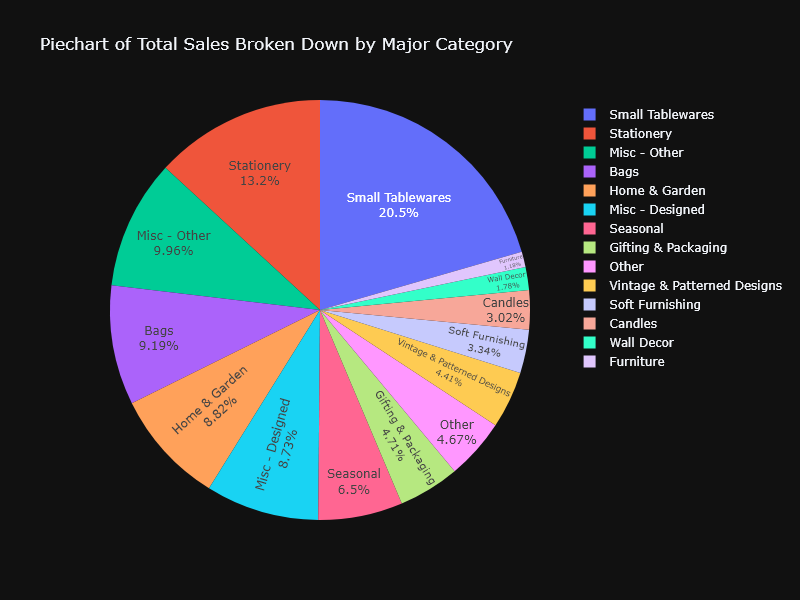

In [ ]:
#Let's display a piechart now that we have some categories that allows us to see what sells the most
category_group = df[['Category', 'TotalPrice']].groupby('Category').sum()
# --- START: New code for grouping small slices ---

# 1. Define the threshold for what constitutes a "small" slice
threshold_percentage = 1.0
total_sales = category_group['TotalPrice'].sum()
threshold_value = (threshold_percentage / 100) * total_sales

# 2. Identify the main categories and the "other" categories
main_categories = category_group[category_group['TotalPrice'] == threshold_value]
other_categories = category_group[category_group['TotalPrice'] < threshold_value]

# 3. If there are small categories, sum them up into an "Other" row
if not other_categories.empty:
    other_sum = other_categories.sum().rename('Other')
    # Use pd.concat to combine the main categories with the new "Other" row
    final_category_group = pd.concat([main_categories, pd.DataFrame([other_sum])])
else:
    final_category_group = main_categories

# --- END: New code for grouping ---

# 4. Plot the new, cleaner data
# We reset the index to use the category names as labels
final_category_group_reset = final_category_group.reset_index()

category_pie = px.pie(final_category_group_reset, 
                      names='index', 
                      values='TotalPrice', 
                      title='Piechart of Total Sales Broken Down by Major Category', 
                      width=800, # Adjusted width for better viewing
                      height=600)

# Improve text display
category_pie.update_traces(textposition='inside', textinfo='percent+label')

#pio.write_image(category_pie, r'notebook referenced files/category_pie_final.png')

Image('notebook referenced files/category_pie_final.png')

**Conclusion: Phase 1**
    
The hybrid approach was highly successful. We transformed an unstructured list of products into 27 meaningful business categories. The pie chart clearly shows that while the business has a wide variety of stock, its primary revenue drivers are **Small Tablewares, Stationery, and various Miscellaneous/Designed goods.**

This categorized data is now ready to be used for more advanced customer-level analysis in the next phase.

---
### **9. Analyzing High-Value Customer Behavior**

Now that the products are categorized, we can analyze the purchasing behavior of the most valuable customers. The first step is to identify these key accounts.

The Pareto Principle often applies in retail, where a small percentage of customers drive a large percentage of revenue. We will test this by identifying the top 20 customers by total sales volume and calculating their contribution to the business's overall revenue. This will serve as the basis for our subsequent visualizations.

In [37]:
#Figure out the top accounts based on Sales Totals
customers_df = df[~df['CustomerID'].isna()]
top_accounts = customers_df[['CustomerID_str', 'TotalPrice']].groupby('CustomerID_str').sum()
top_accounts = top_accounts.sort_values(by='TotalPrice', ascending=False)
top_accounts = top_accounts.reset_index()
top_50_accounts = top_accounts[:20]
top_accounts_list = top_accounts[:20]['CustomerID_str'].to_list()
top_50_percent_sales = np.sum(top_50_accounts['TotalPrice'])/np.sum(df['TotalPrice'])
total_num_accounts = len(np.unique(df['CustomerID_str']))
print(f'The top 20 accounts out of {total_num_accounts} total accounts make up {top_50_percent_sales * 100:.2f}% of all sales')

#Get all the transactions of the top accounts grouped by Stock Code to find most popular items
top_accounts_transactions = df[df['CustomerID_str'].isin(top_accounts_list)]
top_grouped_by_stock = top_accounts_transactions[['CustomerID_str', 'Category', 'TotalPrice']].groupby(['CustomerID_str', 'Category']).sum().reset_index()
top_grouped_stock_reset = top_grouped_by_stock.reset_index()

#Display top account in total sales as example
top_grouped_stock_reset[top_grouped_stock_reset['CustomerID_str'] == top_accounts_list[0]]


The top 20 accounts out of 4335 total accounts make up 20.40% of all sales


,index,CustomerID_str,Category,TotalPrice
148,148,14646,Bags,42271.42
149,149,14646,Candles,6669.98
150,150,14646,Children's Products,7681.05
151,151,14646,Decorative Containers,1044.00
152,152,14646,Fans and Umbrellas,39.50
153,153,14646,Furniture,2265.00
154,154,14646,Gifting & Packaging,23765.54
155,155,14646,Home & Garden,14396.98
156,156,14646,Misc - Designed,13996.00
157,157,14646,Misc - Other,18656.50


#### **9.1. Identifying Core Categories for Top Customers**

To create a clear and readable visualization, it's impractical to display all 27 product categories. We need to identify which categories are most significant *specifically for this high-value customer segment.*

By calculating the total sales per category for just the top 20 accounts, we can determine the core product groups these customers purchase. The analysis below confirms that the top 15 categories account for over 85% of their spending, justifying our decision to focus the visualization on these key areas.

In [38]:
top_regrouped = top_grouped_by_stock[['Category', 'TotalPrice']].groupby('Category').sum().sort_values(by='TotalPrice',ascending=False)
top_regrouped = top_regrouped.reset_index()
top_regrouped_total = np.sum(top_regrouped['TotalPrice'])
top_regrouped['Percent of Total'] = top_regrouped['TotalPrice']/top_regrouped_total * 100
top_regrouped_categories = list(top_regrouped['Category'][:15])
print(f'The Top 15 Categories Make up {np.sum(top_regrouped["Percent of Total"][:15]):.2f} % of Sales for the Top 50 Accounts')
top_regrouped[:15]


The Top 15 Categories Make up 98.30 % of Sales for the Top 50 Accounts


,Category,TotalPrice,Percent of Total
0,Small Tablewares,437281.22,20.86
1,Stationery,421558.50,20.11
2,Bags,172903.36,8.25
3,Home & Garden,162474.74,7.75
4,Misc - Other,155547.33,7.42
5,Vintage & Patterned Designs,151265.98,7.22
6,Misc - Designed,147492.85,7.04
7,Seasonal,99076.08,4.73
8,Gifting & Packaging,89191.57,4.26
9,Soft Furnishing,77018.73,3.67


#### **9.2. Visualizing Purchasing Composition of Top Accounts**
    
The final step is to create a stacked bar chart that visualizes the purchasing composition for each of the top 20 customers. This will allow us to compare their buying habits at a glance.

The process involves:
1.  **Pivoting the Data:** Transforming the data so that each customer is a row, each product category is a column, and the values represent total sales.
2.  **Sorting:** Ensuring the customers on the y-axis are ordered from highest to lowest total sales for intuitive analysis.
3.  **Filtering:** Displaying only the top 15 categories identified in the previous step.
4.  **Plotting:** Generating the final stacked horizontal bar chart.

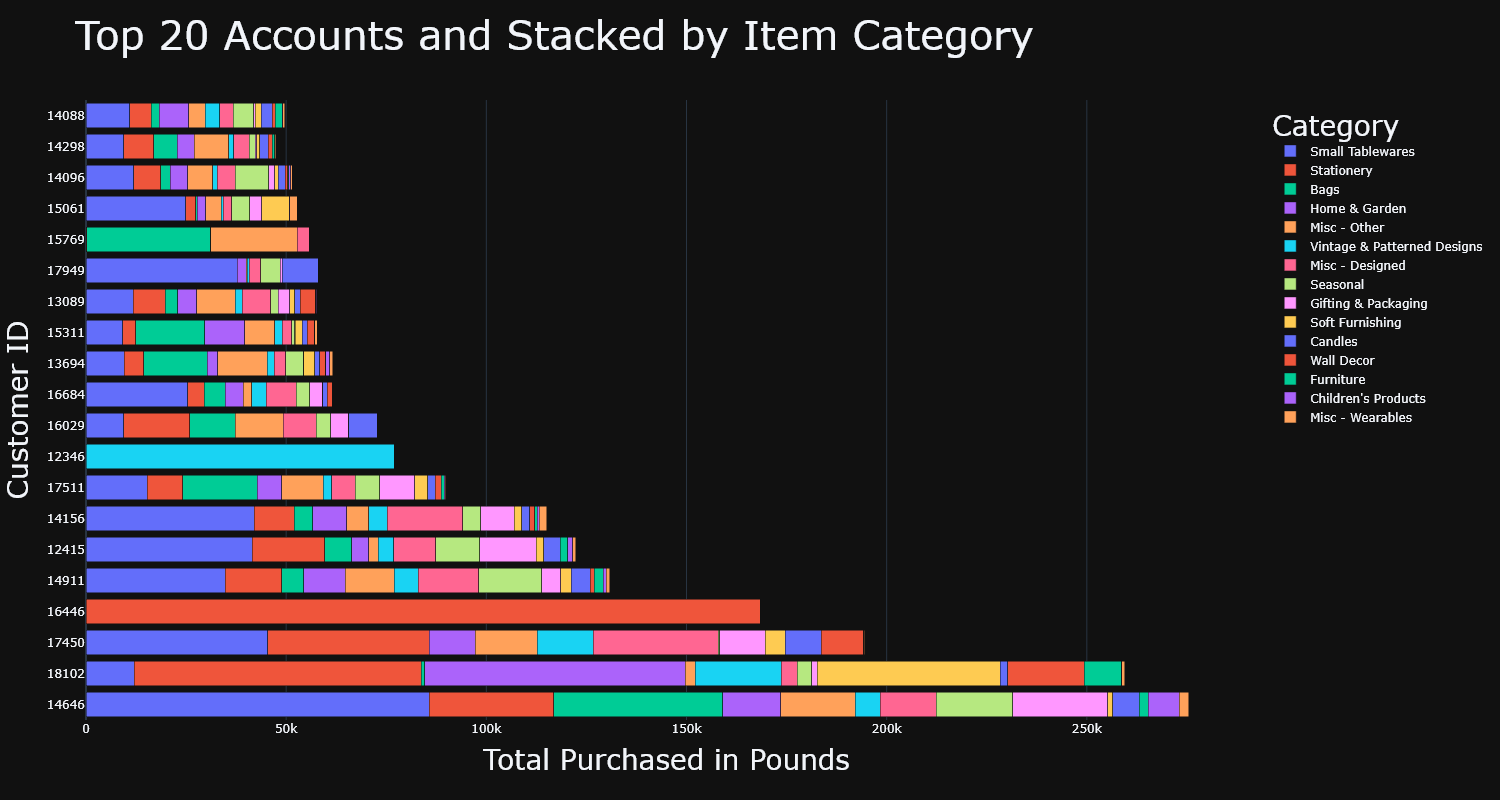

In [ ]:
#Create a dictionary to sort values by based on amounts purchased for the top accounts
top_accounts_sorting = {}
for i in range (0, len(top_accounts_list)):
    top_accounts_sorting[top_accounts_list[i]] = i

#Grouping data by Customer IDs first and Stock Codes second, while summing up the total amounts purchased, then pivoting our dataframe so we can generate the needed data for our stacked bar chart
top_grouped_stock_reset = top_grouped_by_stock.sort_values( by= 'CustomerID_str', key=lambda x:x.map(top_accounts_sorting))
pivot_df = top_grouped_stock_reset.pivot(index='CustomerID_str', columns='Category', values='TotalPrice').fillna(0)
pivot_df = pivot_df.sort_index(level = 1, key=lambda x:x.map(top_accounts_sorting))

#Filtering only the top categories so that the barstack is easier to read
pivot_df_filtered = pivot_df[top_regrouped_categories]


#Plotting our stacked bar chart
fig = px.bar(pivot_df_filtered, orientation='h', title='Top 20 Accounts and Stacked by Item Category')
fig.update_layout(barmode='stack', xaxis_title='Total Purchased in Pounds', yaxis_title='Customer ID', height=800, width = 1500,
# Control the font size for the main title
    title_font_size=40,
    
    # Control the font size for axis titles and tick labels
    font=dict(
        size=20  # Sets the base font size for the chart
    ),
    
    # You can also control individual axis fonts if needed
    xaxis=dict(
        title_font_size=28, # X-axis title font size
        tickfont_size=12    # X-axis tick label font size
    ),
    yaxis=dict(
        title_font_size=28, # Y-axis title font size
        tickfont_size=12    # Y-axis tick label font size
    ),
    
    # Control the font size for the legend
    legend=dict(
        title_font_size=28, # Legend title font size
        font_size=12        # Legend item font size
    )
)

#pio.write_image(fig, r'notebook referenced files/accounts_categories_stacked_bar.png')
Image('notebook referenced files/accounts_categories_stacked_bar.png')


**Figure 4: Analysis of Top Customer Purchasing Habits**
    
This visualization provides several key business insights:
-   **Diverse Habits:** While there are common popular categories (like Small Tablewares and Stationery), the purchasing mix varies significantly from one high-value customer to another.
-   **Category Dominance:** For some customers (e.g., 14156, 17450), a single category makes up a substantial portion of their spending, indicating specialized purchasing needs.
-   **Broad vs. Niche:** Some top customers (e.g., 14646) buy across a wide range of categories, while others are more focused.
    
This analysis confirms that even within the top customer segment, purchasing behavior is not monolithic. This is a critical insight for targeted marketing and inventory management and provides a strong foundation for the next phase: customer segmentation.

In [ ]:
df.to_parquet('Sales with Stock Categories.parquet')